The conclusion is under all the code cells.
I took one of Kaggle kernels dedicated to image analysis as a basis of this notebook. Because the way it has been implemented seems to be deep enough.
Generally, in this problem some dramatic data modifications are not neccessary. However, there are some ways that can improve model perfomance.

In [55]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from skimage.io import imread

In [56]:
%matplotlib inline

In [66]:
images = glob(os.path.join('/Users/artemsokolov/Documents/nuclei_segmentation/data/input/stage1_*', '*', '*', '*.png'))
image_data = pd.DataFrame({'path': images})
image_ids = lambda in_path: in_path.split('/')[-3]
image_types = lambda in_path: in_path.split('/')[-2]
image_group = lambda in_path: in_path.split('/')[-4].split('_')[1]

image_data['ImageId'] = image_data['path'].map(image_ids)
image_data['ImageType'] = image_data['path'].map(image_types)
image_data['TrainingSplit'] = image_data['path'].map(img_group)

# let's delete masks, they are not needed
image_data = image_data.query('ImageType=="images"').drop(['ImageType'],1)
image_data.head(5)

,path,ImageId,TrainingSplit
0,/Users/artemsokolov/Documents/nuclei_segmentat...,519dc0d672d1c295fc69b629af8721ccb1a1f136d19766...,test
1,/Users/artemsokolov/Documents/nuclei_segmentat...,44afae184c89e6ba55985b4d341acc1ae1e8b6ef963120...,test
2,/Users/artemsokolov/Documents/nuclei_segmentat...,5cee644e5ffbef1ba021c7f389b33bafd3b1841f04d3ed...,test
3,/Users/artemsokolov/Documents/nuclei_segmentat...,ade080c6618cbbb0a25680cf847f312b5e19b22bfe1caf...,test
4,/Users/artemsokolov/Documents/nuclei_segmentat...,17b9bf4356db24967c4677b8376ac38f826de73a88b93a...,test


In [67]:
image_data['images'] = image_data['path'].map(imread)
image_data.drop(['path'],1, inplace = True)

In [68]:
#let's check some shapes
image_data['images'].map(lambda x: x.shape).value_counts()

(256, 256, 4)      354
(256, 320, 4)      112
(520, 696, 4)       96
(360, 360, 4)       91
(512, 640, 4)       21
(1024, 1024, 4)     16
(260, 347, 4)        9
(512, 680, 3)        8
(603, 1272, 4)       6
(519, 253, 3)        4
(256, 256, 3)        4
(524, 348, 3)        4
(520, 348, 3)        4
(519, 162, 3)        2
(519, 161, 3)        2
(1040, 1388, 4)      1
(390, 239, 4)        1
Name: images, dtype: int64

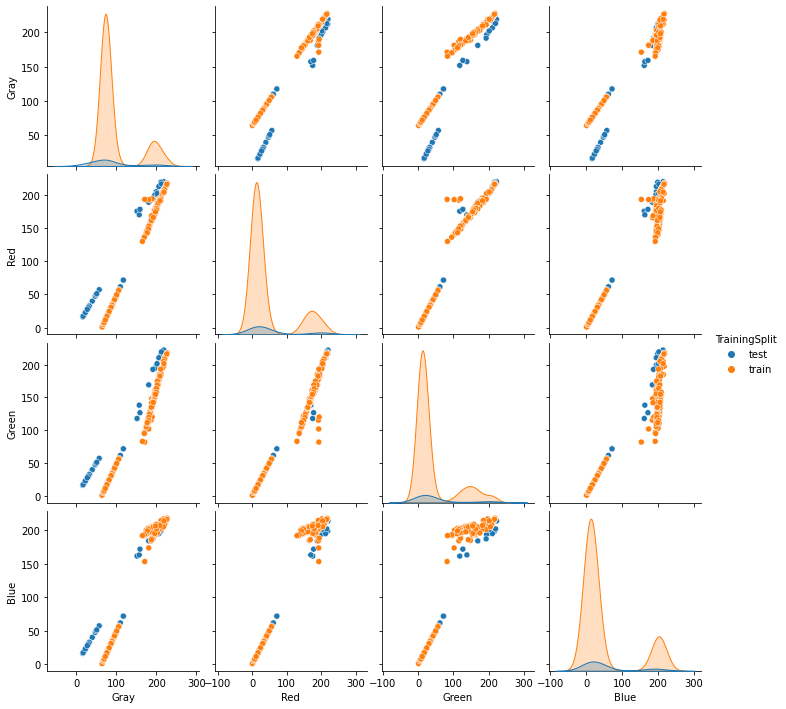

In [60]:
color_features_names = ['Gray', 'Red', 'Green', 'Blue']
def create_color_features(in_df):
    in_df['Red'] = in_df['images'].map(lambda x: np.mean(x[:,:,0]))
    in_df['Green'] = in_df['images'].map(lambda x: np.mean(x[:,:,1]))
    in_df['Blue'] = in_df['images'].map(lambda x: np.mean(x[:,:,2]))
    in_df['Gray'] = in_df['images'].map(lambda x: np.mean(x))
    return in_df

image_data = create_color_features(image_data)
sns.pairplot(img_df[color_features_names+['TrainingSplit']], 
             hue = 'TrainingSplit')

From the plot above we can see that train and test datasets differ. Also, there are several *groups* of data. So let's devide into clusters using KMeans method.

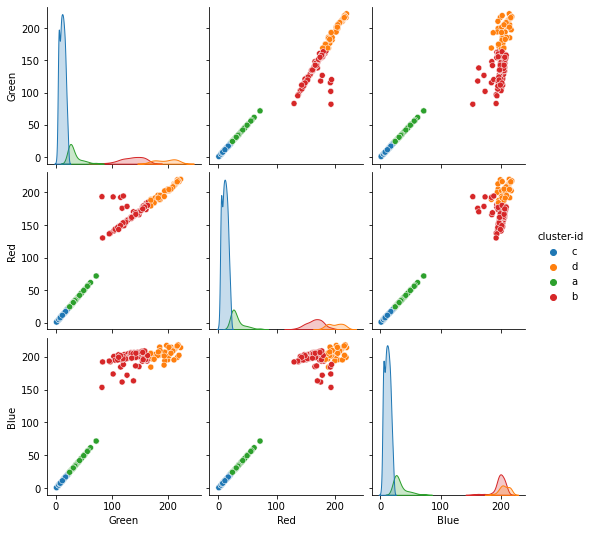

In [61]:
from sklearn.cluster import KMeans
from string import ascii_lowercase

def create_color_cluster(in_df, cluster_maker = None, cluster_count = 3):
    if cluster_maker is None:
        cluster_maker = KMeans(cluster_count)
        cluster_maker.fit(in_df[['Green', 'Red', 'Blue']])
        
    in_df['cluster-id'] = np.argmin(
        cluster_maker.transform(in_df[['Green', 'Red', 'Blue']]),
        -1)
    in_df['cluster-id'] = in_df['cluster-id'].map(lambda x: ascii_lowercase[x])
    return in_df, cluster_maker

image_data, train_cluster_maker = create_color_cluster(image_data, cluster_count=4)
sns.pairplot(image_data, vars = ['Green', 'Red', 'Blue'], hue = 'cluster-id')

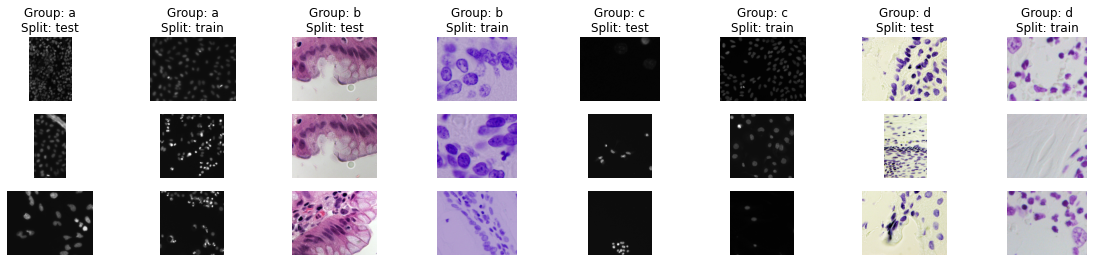

In [64]:
n_img = 3
grouper = image_data.groupby(['cluster-id', 'TrainingSplit'])
fig, m_axs = plt.subplots(n_img, len(grouper), 
                          figsize = (20, 4))
for (c_group, clus_group), c_ims in zip(grouper, 
                                     m_axs.T):
    c_ims[0].set_title('Group: {}\nSplit: {}'.format(*c_group))
    for (_, clus_row), c_im in zip(clus_group.sample(n_img, replace = True).iterrows(), c_ims):
        c_im.imshow(clus_row['images'])
        c_im.axis('off')

In [65]:
tiny_img_df = grouper.apply(lambda x: x.sample(n_img if n_img<x.shape[0] else x.shape[0])
                           ).reset_index(drop=True).drop(color_features_names, 1).sort_values(['cluster-id', 'TrainingSplit'])
print(tiny_img_df.shape[0], 'images to experiment with')
tiny_img_df.sample(2)

24 images to experiment with


,ImageId,TrainingSplit,Stage,images,cluster-id
19,f5effed21f671bbf4551ecebb7fe95f3be1cf09c16a60a...,test,stage1,"[[[141, 94, 129], [120, 70, 133], [106, 53, 14...",d
14,8922a6ac8fd0258ec27738ca101867169b20d90a60fc84...,test,stage1,"[[[0, 0, 0, 255], [0, 0, 0, 255], [1, 1, 1, 25...",c


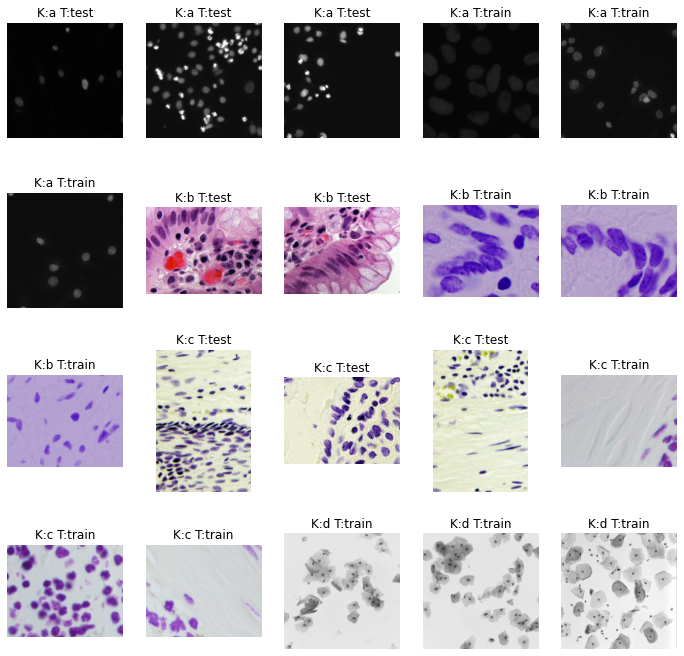

In [37]:
def show_test_img(in_df, in_col):
    plt_cols = tiny_img_df.shape[0]//4
    fig, m_axs = plt.subplots(4, plt_cols, figsize = (12, 12))
    for c_ax, (_, c_row) in zip(m_axs.flatten(), in_df.iterrows()):
        c_ax.imshow(c_row[in_col])
        c_ax.axis('off')
        c_ax.set_title('K:{cluster-id} T:{TrainingSplit}'.format(**c_row))
show_test_img(tiny_img_df, 'images')

From the above EDA we can see that train and test data differ dramatically. Therefore several methods can be used in order to normalize them. During training the Dice coefficient was equal to 0.87 on the validation set and that seems to be the good result. However, the distributions of the training and test data should ve similar. Therefore several methods have been proposed. 
Firstly, histogram equalization can be applied using CLAHE algorithm. Thus we'll be able then to keep only the L channel, as it also has been proposed by some of Kaggle users. As a result of all this action the train data and test data are supposed to have more similar distributions and it will influence the model perfomance. However, seemingly it was not the main task of the test work so I have not prerformed that. 